# Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cv2

DEVICE = 'cuda'


# Using pretrained ResNet(18)

In [2]:
import torchvision.models as models #To load the ResNet model from the torchvision

#Import the models you want from torchvision or write from scratch
model = models.resnet18(pretrained=True)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7))

c:\Users\goytom\anaconda3\envs\djene\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\goytom\anaconda3\envs\djene\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Select the model to be used 

In [3]:
cl_model = model #For the ResNet pre-trained network
cl_model.to(DEVICE) #Load the models to GPU

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Dataloader and preprocessing

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import random
import matplotlib.pyplot as plt

#Path to the dataset
TRAIN_IMG_FOLDER_PATH = "C:/Users/goytom/Desktop/m_vis/data_X_SDD/train_set"
VALID_IMG_FOLDER_PATH = "C:/Users/goytom/Desktop/m_vis/data_X_SDD/test_set"

train_augs = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, + 20)),
    T.ToTensor() # Convert a PIL image or numpy.ndarray to tensor (h, w, c) --> (c, h, w)
])

valid_augs = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])


trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

print(trainset.class_to_idx)

Total no. of examples in trainset : 949
Total no. of examples in validset : 411
{'finishing_roll_printing': 0, 'iron_sheet_ash': 1, 'oxide_scale_of_plate': 2, 'oxide_scale_of_temperature': 3, 'red_iron': 4, 'slag_inclusion': 5, 'surface_scratch': 6}


Text(0.5, 1.0, 'oxide_scale_of_plate')

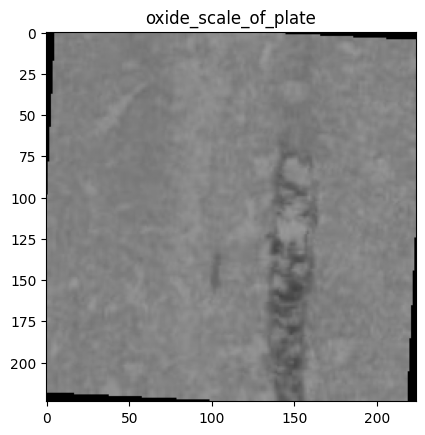

In [5]:
class_names = trainset.classes

index = random.randint(0, len(trainset)-1)
image, label = trainset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

Text(0.5, 1.0, 'slag_inclusion')

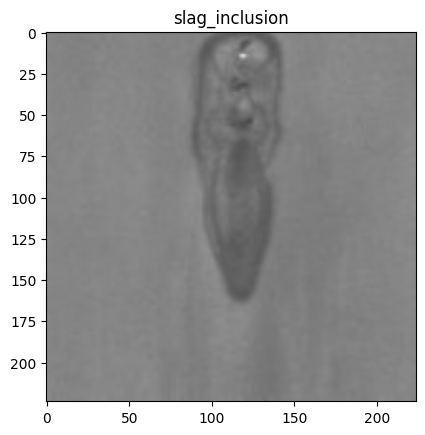

In [6]:
class_names = validset.classes

index = random.randint(0, len(validset)-1)
image, label = validset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(trainset, batch_size = 16, shuffle = True)
test_loader = DataLoader(validset, batch_size = 16)

print(f"Total no. of batches in trainloader : {len(train_loader)}")
print(f"Total no. of batches in validloader : {len(test_loader)}")

Total no. of batches in trainloader : 60
Total no. of batches in validloader : 26


In [8]:
for images, labels in train_loader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([16, 3, 224, 224])
One label batch shape : torch.Size([16])


# Model Training

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cl_model.parameters(), lr=0.001)
train_loss_history = []
train_acc_history = []
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    cl_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = cl_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    average_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train
    train_loss_history.append(average_loss)
    train_acc_history.append(accuracy_train)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Training Accuracy: {100 * accuracy_train:.2f}%')

# Save the trained model
model_path = 'defect_detection_ResNet18.pth' #Change the path and name accordingly
torch.save(cl_model.state_dict(), model_path)
print(f'Model saved to {model_path}')



Epoch [1/50], Loss: 0.8768, Training Accuracy: 71.87%
Epoch [2/50], Loss: 0.4778, Training Accuracy: 83.88%
Epoch [3/50], Loss: 0.3934, Training Accuracy: 86.93%
Epoch [4/50], Loss: 0.4408, Training Accuracy: 86.20%
Epoch [5/50], Loss: 0.2808, Training Accuracy: 91.99%
Epoch [6/50], Loss: 0.2730, Training Accuracy: 90.94%
Epoch [7/50], Loss: 0.2409, Training Accuracy: 91.57%
Epoch [8/50], Loss: 0.2489, Training Accuracy: 93.15%
Epoch [9/50], Loss: 0.1768, Training Accuracy: 94.63%
Epoch [10/50], Loss: 0.2841, Training Accuracy: 90.41%
Epoch [11/50], Loss: 0.1438, Training Accuracy: 95.89%
Epoch [12/50], Loss: 0.1414, Training Accuracy: 94.63%
Epoch [13/50], Loss: 0.1420, Training Accuracy: 96.21%
Epoch [14/50], Loss: 0.1643, Training Accuracy: 94.10%
Epoch [15/50], Loss: 0.1262, Training Accuracy: 96.31%
Epoch [16/50], Loss: 0.1026, Training Accuracy: 96.94%
Epoch [17/50], Loss: 0.1761, Training Accuracy: 94.63%
Epoch [18/50], Loss: 0.1641, Training Accuracy: 95.26%
Epoch [19/50], Loss

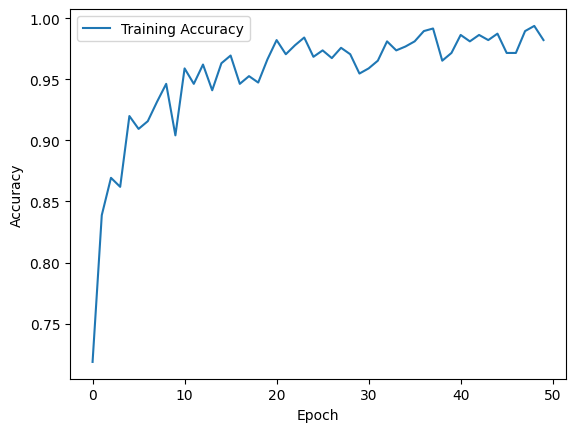

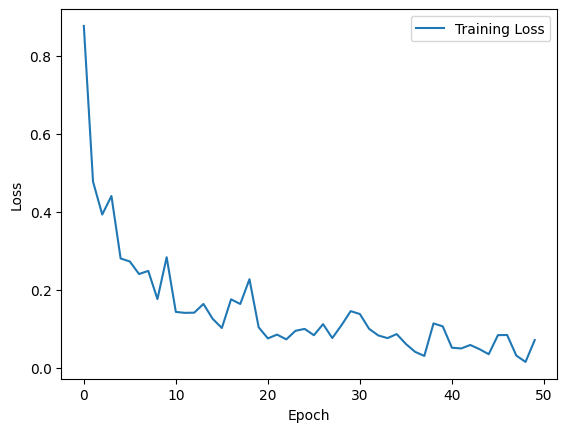

In [10]:
# Plot training accuracy
plt.plot(train_acc_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation on the test set

In [11]:

cl_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = cl_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

Test Accuracy: 97.08%


# INFERENCE

In [12]:
def view_classify(img, ps):
  
    classes = ['finishing_roll_printing', 'iron_sheet_ash','oxide_scale_of_plate', 
               'oxide_scale_of_temperature', 'red_iron', 'slag_inclusion', 'surface_scratch']
    
    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
    
    fig, (ax1, ax2) = plt.subplots(figsize = (5,9), ncols = 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    
    return None

In [13]:
PATH = "C:/Users/djmen/Desktop/m_vis/defect_detection_ResNet18.pth"

cl_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

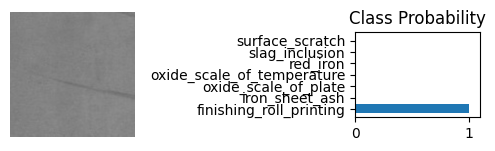

In [14]:
image, label = validset[51]
image = image.unsqueeze(0)

logits = cl_model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)